# NNIA Assignment 9

**DEADLINE: 26. 1. 2022 08:00 CET**
Submission more than 10 minutes past the deadline will **not** be graded!

- Trevor Atkins & trat00001@uni-saarland.de:
- Tsimafei Prakapenka & tspr00001@uni-saarland.de:
- Hours of work per person: Prakapenka ~6.5h
- Group nickname:

# Submission Instructions

**IMPORTANT** Please make sure you read the following instructions carefully. If you are unclear about any part of the assignment, ask questions **before** the assignment deadline. All course-related questions can be addressed on the course **[Piazza Platform](https://piazza.com/class/kvc3vzhsvh55rt)**.

* Assignments are to be submitted in a **team of 2**.
* Please include your **names**, **ID's**, **Teams usernames**, and **approximate total time spent per person** at the beginning of the Notebook in the space provided
* Make sure you appropriately comment your code wherever required.
* Your final submission should contain this completed Jupyter Notebook, including the bonus question (if you attempt it), and any necessary Python files.
* Do **not** submit any data or cache files (e.g. `__pycache__`).
* Upload the **zipped** folder (*.zip* is the only accepted extension) in **Teams**.
* Only **one member** of the group should make the submisssion.
* **Important** please name the submitted zip folder as: `Name1_id1_Name2_id2.zip`. The Jupyter Notebook should also be named: `Name1_id1_Name2_id2.ipynb`. This is **very important** for our internal organization epeatedly students fail to do this.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1 Diacritization (9 points)

The English alphabet has 26 letters. This is not the case for Czech (and many more European languages), which has many more extra letters, namely those with a simple accent (čárka, lit. "short line segment"): `áéíýúó`, those with a little hook (háček): `ěčšžř` and those with a circle (kroužek) `ů`.
They change the pronounciations of the words (mostly palatalization) and also distinguish words (there are many words which differ only by diacritics). 
Typing words without these accents is considered to be rude (and annoying to read).
Imagine you've been tasked by a telecommunication company to come up with a system to automatically add all the accents correctly given a word without accents.
Each line in the input contains two words: with and without accents, e.g.: `cerveneho červeného`.
We provide the train/dev split for you (in separate files) and also a test file without correct answers.

Your task is to create two neural networks character-level models that add the diacritization back to the word.

## 1.1 Baseline (1 points)

- Plot the distribution of classes (there are 4)
- Evaluate the accuracy of most common class classifier

In [2]:
! pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0c541db081f17c5e82beebd39d34f99e02c101644604e234ed1f23caa6d5c745
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import os
import wget

import torch
from torch import nn

from typing import List, Tuple, Generator, Union, Dict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

In [4]:
if not os.path.isfile('solution.py'):
    wget.download('https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Neural_Networks/HW9_solution.py', 'solution.py')

In [5]:
from solution import download_data_files

train_filename = 'words_random_train.txt'
dev_filename = 'words_random_dev.txt'
test_filename = 'words_random_test_blind.txt'

download_data_files([train_filename, dev_filename, test_filename])

In [6]:
with open(train_filename, "r") as f:
    train_data = list(map(str.split, f.readlines()))

with open(dev_filename, "r") as f:
    dev_data = list(map(str.split, f.readlines()))

with open(test_filename, "r") as f:
    test_data = [line.strip() for line in f.readlines()]

print(train_data[1], dev_data[1], test_data[1])

['nájemřidiči', 'najemridici'] ['neodmyslitelné', 'neodmyslitelne'] transvestite


In [7]:
classlabel_to_classname = {0: 'nothing', 1: 'čárka', 2: 'háček', 3: 'kroužek'}
classlabel_to_char = {1: ['á','é','í','ý','ú','ó'], 2: ['ě','č','š','ž','ř'], 3: ['ů']}

# I use defaultdict to handle 0-class more smoothly
char_to_classlabel = defaultdict(int)
char_to_classlabel.update({
    class_char: class_label 
    for class_label, class_chars in classlabel_to_char.items() 
    for class_char in class_chars
})
print(char_to_classlabel)

defaultdict(<class 'int'>, {'á': 1, 'é': 1, 'í': 1, 'ý': 1, 'ú': 1, 'ó': 1, 'ě': 2, 'č': 2, 'š': 2, 'ž': 2, 'ř': 2, 'ů': 3})


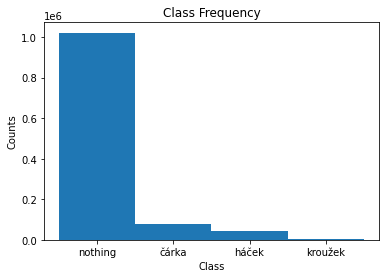

{'nothing': 1021576, 'čárka': 78545, 'háček': 42728, 'kroužek': 2601}
{'nothing': 0.8918556026015976, 'čárka': 0.06857130385438037, 'háček': 0.03730237024750098, 'kroužek': 0.002270723296521018}


In [8]:
from solution import distribution

classname_to_count = distribution(
    train_data=train_data, 
    classlabel_to_classname=classlabel_to_classname, 
    char_to_classlabel=char_to_classlabel,
)
print(classname_to_count)

all_count = sum(classname_to_count.values())
classname_to_percentage = {
    class_name: class_count/all_count 
    for class_name, class_count in classname_to_count.items()
}
print(classname_to_percentage)

So, defaulting to nothing class will give us ~0.89 accuracy. Definitely not bad for a start.

## 1.2 Sliding windows (3 points)

The first model is based on sliding windows, e.g. it considers the current character and two characters to the left and two characters to the right for context.
You should also add padding tokens to the left and to the right so that you can classify the corner characters as well:

```
__Cer -> HOOK
_cErv -> NOTHING
ceRve -> NOTHING
erVen -> NOTHING
rvEne -> NOTHING
veNeh -> NOTHING
enEho -> SIMPLE ACCENT
neHo_ -> NOTHING
ehO__ -> NOTHING
```


Build a sliding-window neural network with the best architecture and hyperparameters and report your accuracies on train and dev datasets.
Additionally, provide the output for the test file.

In [9]:
BATCH_SIZE = 128
INPUT_SIZE = 130
HIDDEN_SIZE = 32
NUM_CLASSES = 4

DROPOUT = 0.25

In [10]:
from solution import prepare_sliding_data

X_train, y_train = prepare_sliding_data(train_data, char_to_classlabel)
X_dev, y_dev = prepare_sliding_data(dev_data, char_to_classlabel)
X_test = prepare_sliding_data(test_data, char_to_classlabel)

In [11]:
X_train[0], y_train[0], len(X_train), len(X_dev)

('__nei', 0, 1145450, 190499)

In [12]:
from solution import encode_sliding_data

sample_encoding = encode_sliding_data(X_train[0])
print(X_train[0], len(sample_encoding))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] __nei 130


In [13]:
from solution import CustomSlidingDataset
from torch.utils.data import DataLoader

train_dataset = CustomSlidingDataset(X_train, y_train)
validation_dataset = CustomSlidingDataset(X_dev, y_dev)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE*4, shuffle=True)

In [18]:
import torch.nn.functional as F

class DiacriticFFNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(130, 72)
        self.bn1 = nn.BatchNorm1d(num_features=72)
        self.linear2 = nn.Linear(72, 4)

        self.dropout = nn.Dropout(0.2)

    def forward(self, input: torch.Tensor):  # Input is a 1D tensor
        y = self.dropout(F.relu(self.bn1(self.linear1(input))))
        y = self.linear2(y)
        return y

In [20]:
from solution import run_train_and_val

model = DiacriticFFNN()
best_val_loss, best_metrics = run_train_and_val(model, train_dataloader, validation_dataloder, epochs=50)

0 

100%|██████████| 373/373 [00:01<00:00, 224.36it/s]


1 

100%|██████████| 373/373 [00:01<00:00, 209.89it/s]



Epoch 2
-------------------------------
Train metrics:  {'loss': 0.23229829478558914, 'accuracy': 0.9220288969400672, 'predicted_labels': defaultdict(<class 'int'>, {0: 1091008, 1: 50816, 2: 3626}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.20327837683320366, 'accuracy': 0.9286295466117932, 'predicted_labels': defaultdict(<class 'int'>, {0: 179644, 1: 9270, 2: 1585}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
2 

100%|██████████| 373/373 [00:01<00:00, 227.10it/s]


3 

100%|██████████| 373/373 [00:01<00:00, 226.62it/s]



Epoch 4
-------------------------------
Train metrics:  {'loss': 0.1793436402231638, 'accuracy': 0.9334113230608058, 'predicted_labels': defaultdict(<class 'int'>, {0: 1067272, 1: 60379, 2: 17799}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.1715506498998995, 'accuracy': 0.9363041275807222, 'predicted_labels': defaultdict(<class 'int'>, {0: 176991, 1: 10201, 2: 3307}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
4 

100%|██████████| 373/373 [00:01<00:00, 213.57it/s]


5 

100%|██████████| 373/373 [00:01<00:00, 229.47it/s]



Epoch 6
-------------------------------
Train metrics:  {'loss': 0.16417306526897607, 'accuracy': 0.9380854685931294, 'predicted_labels': defaultdict(<class 'int'>, {0: 1060896, 2: 21981, 1: 62569, 3: 4}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.15905953803906173, 'accuracy': 0.9402306573787789, 'predicted_labels': defaultdict(<class 'int'>, {0: 176296, 2: 3941, 1: 10260, 3: 2}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
6 

100%|██████████| 373/373 [00:01<00:00, 226.83it/s]


7 

100%|██████████| 373/373 [00:01<00:00, 211.98it/s]



Epoch 8
-------------------------------
Train metrics:  {'loss': 0.1557097856272984, 'accuracy': 0.9406399231742983, 'predicted_labels': defaultdict(<class 'int'>, {0: 1057202, 1: 63780, 2: 24402, 3: 66}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.15144204328350983, 'accuracy': 0.942577126389115, 'predicted_labels': defaultdict(<class 'int'>, {1: 10496, 0: 175775, 2: 4216, 3: 12}), 'gold_labels': defaultdict(<class 'int'>, {1: 12887, 0: 170148, 2: 7002, 3: 462})}

-------------------------------
8 

100%|██████████| 373/373 [00:01<00:00, 227.44it/s]


9 

100%|██████████| 373/373 [00:01<00:00, 228.55it/s]



Epoch 10
-------------------------------
Train metrics:  {'loss': 0.14998485957118224, 'accuracy': 0.9427019948491859, 'predicted_labels': defaultdict(<class 'int'>, {0: 1054753, 1: 64375, 2: 26097, 3: 225}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.14600290224235754, 'accuracy': 0.943983957921039, 'predicted_labels': defaultdict(<class 'int'>, {0: 175484, 1: 10548, 2: 4428, 3: 39}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
10 

100%|██████████| 373/373 [00:01<00:00, 226.29it/s]


11 

100%|██████████| 373/373 [00:01<00:00, 209.21it/s]



Epoch 12
-------------------------------
Train metrics:  {'loss': 0.14566947851679302, 'accuracy': 0.9440438255707364, 'predicted_labels': defaultdict(<class 'int'>, {0: 1052999, 2: 27255, 1: 64804, 3: 392}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.14308388193634816, 'accuracy': 0.9457372479645563, 'predicted_labels': defaultdict(<class 'int'>, {0: 175084, 1: 10717, 2: 4613, 3: 85}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
12 

100%|██████████| 373/373 [00:01<00:00, 230.32it/s]


13 

100%|██████████| 373/373 [00:01<00:00, 225.99it/s]



Epoch 14
-------------------------------
Train metrics:  {'loss': 0.14246063294647418, 'accuracy': 0.9453777991182505, 'predicted_labels': defaultdict(<class 'int'>, {0: 1051378, 2: 28282, 1: 65206, 3: 584}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.13914577892654384, 'accuracy': 0.9461991926466805, 'predicted_labels': defaultdict(<class 'int'>, {0: 174909, 2: 4854, 1: 10650, 3: 86}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
14 

100%|██████████| 373/373 [00:01<00:00, 216.61it/s]


15 

100%|██████████| 373/373 [00:01<00:00, 227.33it/s]



Epoch 16
-------------------------------
Train metrics:  {'loss': 0.13981524162041914, 'accuracy': 0.9464516129032258, 'predicted_labels': defaultdict(<class 'int'>, {0: 1050131, 1: 65607, 2: 28973, 3: 739}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.13710701273849119, 'accuracy': 0.9474852886366858, 'predicted_labels': defaultdict(<class 'int'>, {0: 174652, 2: 4946, 1: 10784, 3: 117}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
16 

100%|██████████| 373/373 [00:01<00:00, 227.60it/s]


17 

100%|██████████| 373/373 [00:01<00:00, 217.11it/s]



Epoch 18
-------------------------------
Train metrics:  {'loss': 0.13740512585823783, 'accuracy': 0.9472870924090968, 'predicted_labels': defaultdict(<class 'int'>, {0: 1048941, 1: 65880, 2: 29754, 3: 875}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.1347821473715772, 'accuracy': 0.94808896634628, 'predicted_labels': defaultdict(<class 'int'>, {0: 174562, 1: 10794, 2: 5003, 3: 140}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 3: 462, 2: 7002})}

-------------------------------
18 

100%|██████████| 373/373 [00:01<00:00, 226.16it/s]


19 

100%|██████████| 373/373 [00:01<00:00, 229.43it/s]



Epoch 20
-------------------------------
Train metrics:  {'loss': 0.135636412452314, 'accuracy': 0.9478117770308613, 'predicted_labels': defaultdict(<class 'int'>, {0: 1048245, 2: 30258, 1: 66013, 3: 934}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.13272615649984607, 'accuracy': 0.9492280799374275, 'predicted_labels': defaultdict(<class 'int'>, {0: 174203, 1: 10938, 2: 5191, 3: 167}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
20 

100%|██████████| 373/373 [00:01<00:00, 211.11it/s]


21 

100%|██████████| 373/373 [00:01<00:00, 225.25it/s]



Epoch 22
-------------------------------
Train metrics:  {'loss': 0.13379305808885375, 'accuracy': 0.9484420969924484, 'predicted_labels': defaultdict(<class 'int'>, {0: 1047556, 1: 66212, 2: 30659, 3: 1023}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.1311983488120598, 'accuracy': 0.9497267702192662, 'predicted_labels': defaultdict(<class 'int'>, {0: 174250, 2: 5130, 1: 10948, 3: 171}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
22 

100%|██████████| 373/373 [00:01<00:00, 228.74it/s]


23 

100%|██████████| 373/373 [00:01<00:00, 225.14it/s]



Epoch 24
-------------------------------
Train metrics:  {'loss': 0.13241156163034407, 'accuracy': 0.9490811471474093, 'predicted_labels': defaultdict(<class 'int'>, {0: 1046630, 1: 66573, 2: 31171, 3: 1076}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.13012031803342036, 'accuracy': 0.9498580045039606, 'predicted_labels': defaultdict(<class 'int'>, {0: 174196, 3: 189, 1: 10939, 2: 5175}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 3: 462, 1: 12887})}

-------------------------------
24 

100%|██████████| 373/373 [00:01<00:00, 210.02it/s]


25 

100%|██████████| 373/373 [00:01<00:00, 228.36it/s]



Epoch 26
-------------------------------
Train metrics:  {'loss': 0.13119678056215772, 'accuracy': 0.949585752324414, 'predicted_labels': defaultdict(<class 'int'>, {1: 66782, 0: 1046062, 2: 31483, 3: 1123}), 'gold_labels': defaultdict(<class 'int'>, {1: 78545, 0: 1021576, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.1286320160005751, 'accuracy': 0.9508973800387404, 'predicted_labels': defaultdict(<class 'int'>, {0: 174185, 1: 10833, 2: 5279, 3: 202}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
26 

100%|██████████| 373/373 [00:01<00:00, 225.05it/s]


27 

100%|██████████| 373/373 [00:01<00:00, 211.81it/s]



Epoch 28
-------------------------------
Train metrics:  {'loss': 0.13027920656831174, 'accuracy': 0.950033611244489, 'predicted_labels': defaultdict(<class 'int'>, {0: 1045514, 1: 66885, 2: 31842, 3: 1209}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12783061852803498, 'accuracy': 0.9515797983191513, 'predicted_labels': defaultdict(<class 'int'>, {0: 173819, 1: 11048, 2: 5426, 3: 206}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
28 

100%|██████████| 373/373 [00:01<00:00, 226.39it/s]


29 

100%|██████████| 373/373 [00:01<00:00, 227.83it/s]



Epoch 30
-------------------------------
Train metrics:  {'loss': 0.1291351167095688, 'accuracy': 0.9504500414684185, 'predicted_labels': defaultdict(<class 'int'>, {0: 1045047, 2: 31951, 1: 67232, 3: 1220}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.12662074541118765, 'accuracy': 0.9513855715778036, 'predicted_labels': defaultdict(<class 'int'>, {0: 173891, 2: 5407, 1: 10970, 3: 231}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
30 

100%|██████████| 373/373 [00:01<00:00, 228.83it/s]


31 

100%|██████████| 373/373 [00:01<00:00, 213.23it/s]



Epoch 32
-------------------------------
Train metrics:  {'loss': 0.12813504056892444, 'accuracy': 0.95090575756253, 'predicted_labels': defaultdict(<class 'int'>, {0: 1044668, 1: 67244, 2: 32269, 3: 1269}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12611189271865197, 'accuracy': 0.9519157580879689, 'predicted_labels': defaultdict(<class 'int'>, {0: 173626, 1: 11130, 2: 5507, 3: 236}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
32 

100%|██████████| 373/373 [00:01<00:00, 226.76it/s]


33 

100%|██████████| 373/373 [00:01<00:00, 229.13it/s]



Epoch 34
-------------------------------
Train metrics:  {'loss': 0.12719984583499205, 'accuracy': 0.951311711554411, 'predicted_labels': defaultdict(<class 'int'>, {0: 1043957, 2: 32556, 1: 67640, 3: 1297}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12545789015197242, 'accuracy': 0.9524669420836854, 'predicted_labels': defaultdict(<class 'int'>, {0: 173603, 1: 11184, 2: 5489, 3: 223}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
34 

100%|██████████| 373/373 [00:01<00:00, 226.95it/s]


35 

100%|██████████| 373/373 [00:01<00:00, 215.55it/s]



Epoch 36
-------------------------------
Train metrics:  {'loss': 0.1268027475153065, 'accuracy': 0.9515159980793575, 'predicted_labels': defaultdict(<class 'int'>, {0: 1043559, 2: 32813, 1: 67740, 3: 1338}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12480977629049214, 'accuracy': 0.9524669420836854, 'predicted_labels': defaultdict(<class 'int'>, {0: 173514, 2: 5532, 1: 11221, 3: 232}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
36 

100%|██████████| 373/373 [00:01<00:00, 229.31it/s]


37 

100%|██████████| 373/373 [00:01<00:00, 226.44it/s]



Epoch 38
-------------------------------
Train metrics:  {'loss': 0.12559237048206404, 'accuracy': 0.9520782225326291, 'predicted_labels': defaultdict(<class 'int'>, {0: 1043256, 2: 33001, 1: 67824, 3: 1369}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.1237928317235558, 'accuracy': 0.9526979144247476, 'predicted_labels': defaultdict(<class 'int'>, {0: 173539, 1: 11163, 2: 5563, 3: 234}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
38 

100%|██████████| 373/373 [00:01<00:00, 224.75it/s]


39 

100%|██████████| 373/373 [00:01<00:00, 215.01it/s]



Epoch 40
-------------------------------
Train metrics:  {'loss': 0.1251786167999062, 'accuracy': 0.9521140163254616, 'predicted_labels': defaultdict(<class 'int'>, {0: 1043202, 1: 67821, 2: 33079, 3: 1348}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12369438256798737, 'accuracy': 0.9527189119102988, 'predicted_labels': defaultdict(<class 'int'>, {0: 173288, 1: 11324, 3: 263, 2: 5624}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 3: 462, 2: 7002})}

-------------------------------
40 

100%|██████████| 373/373 [00:01<00:00, 227.03it/s]


41 

100%|██████████| 373/373 [00:01<00:00, 223.43it/s]



Epoch 42
-------------------------------
Train metrics:  {'loss': 0.12458816952841058, 'accuracy': 0.9523855253393863, 'predicted_labels': defaultdict(<class 'int'>, {1: 68047, 0: 1042636, 2: 33384, 3: 1383}), 'gold_labels': defaultdict(<class 'int'>, {1: 78545, 0: 1021576, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12259340641805377, 'accuracy': 0.9535063176184652, 'predicted_labels': defaultdict(<class 'int'>, {0: 173452, 1: 11215, 2: 5576, 3: 256}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
42 

100%|██████████| 373/373 [00:01<00:00, 218.26it/s]


43 

100%|██████████| 373/373 [00:01<00:00, 230.76it/s]



Epoch 44
-------------------------------
Train metrics:  {'loss': 0.1241305366996041, 'accuracy': 0.952523462394692, 'predicted_labels': defaultdict(<class 'int'>, {0: 1042443, 2: 33423, 1: 68136, 3: 1448}), 'gold_labels': defaultdict(<class 'int'>, {1: 78545, 0: 1021576, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12259720064120382, 'accuracy': 0.9536428012745474, 'predicted_labels': defaultdict(<class 'int'>, {1: 11418, 0: 173127, 2: 5710, 3: 244}), 'gold_labels': defaultdict(<class 'int'>, {1: 12887, 0: 170148, 2: 7002, 3: 462})}

-------------------------------
44 

100%|██████████| 373/373 [00:01<00:00, 226.80it/s]


45 

100%|██████████| 373/373 [00:01<00:00, 213.10it/s]



Epoch 46
-------------------------------
Train metrics:  {'loss': 0.12384688247197939, 'accuracy': 0.9525653673228862, 'predicted_labels': defaultdict(<class 'int'>, {0: 1042099, 1: 68319, 2: 33613, 3: 1419}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.122071800279074, 'accuracy': 0.9536480506459352, 'predicted_labels': defaultdict(<class 'int'>, {0: 173475, 1: 11150, 2: 5626, 3: 248}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
46 

100%|██████████| 373/373 [00:01<00:00, 228.03it/s]


47 

100%|██████████| 373/373 [00:01<00:00, 227.61it/s]



Epoch 48
-------------------------------
Train metrics:  {'loss': 0.1230273249849772, 'accuracy': 0.9529599720633812, 'predicted_labels': defaultdict(<class 'int'>, {0: 1041719, 1: 68491, 2: 33787, 3: 1453}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12108424817269353, 'accuracy': 0.9536218037889963, 'predicted_labels': defaultdict(<class 'int'>, {0: 173482, 2: 5613, 3: 254, 1: 11150}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 3: 462, 1: 12887, 2: 7002})}

-------------------------------
48 

100%|██████████| 373/373 [00:01<00:00, 226.61it/s]


49 

100%|██████████| 373/373 [00:01<00:00, 210.09it/s]


Epoch 50
-------------------------------
Train metrics:  {'loss': 0.12246514986278438, 'accuracy': 0.9530638613645293, 'predicted_labels': defaultdict(<class 'int'>, {1: 68460, 0: 1041603, 2: 33942, 3: 1445}), 'gold_labels': defaultdict(<class 'int'>, {1: 78545, 0: 1021576, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.12096434895538453, 'accuracy': 0.9540102572716918, 'predicted_labels': defaultdict(<class 'int'>, {0: 173386, 2: 5729, 1: 11139, 3: 245}), 'gold_labels': defaultdict(<class 'int'>, {1: 12887, 0: 170148, 2: 7002, 3: 462})}

-------------------------------
Done!


In [35]:
import torch.nn.functional as F

class DiacriticFFNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(130, 78)
        self.bn1 = nn.BatchNorm1d(num_features=78)
        self.linear2 = nn.Linear(78, 26)
        self.bn2 = nn.BatchNorm1d(num_features=26)
        self.linear3 = nn.Linear(26, 4)

        self.dropout = nn.Dropout(0.2)

    def forward(self, input: torch.Tensor):  # Input is a 1D tensor
        y = self.dropout(F.relu(self.bn1(self.linear1(input))))
        y = self.dropout(F.relu(self.bn2(self.linear2(y))))
        y = self.linear3(y)
        return y

In [ ]:
from solution import run_train_and_val

model = DiacriticFFNN()
best_val_loss, best_metrics = run_train_and_val(model, train_dataloader, validation_dataloader, epochs=50)

0 

100%|██████████| 373/373 [00:01<00:00, 221.95it/s]


1 

100%|██████████| 373/373 [00:01<00:00, 211.24it/s]



Epoch 2
-------------------------------
Train metrics:  {'loss': 0.34536900994817377, 'accuracy': 0.9115823475489983, 'predicted_labels': defaultdict(<class 'int'>, {0: 1101928, 1: 42903, 2: 591, 3: 28}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.2674701850232106, 'accuracy': 0.9154903700281891, 'predicted_labels': defaultdict(<class 'int'>, {0: 182849, 1: 7614, 2: 33, 3: 3}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
2 

100%|██████████| 373/373 [00:01<00:00, 219.25it/s]


3 

100%|██████████| 373/373 [00:01<00:00, 220.22it/s]



Epoch 4
-------------------------------
Train metrics:  {'loss': 0.2123989954196164, 'accuracy': 0.9237679514601248, 'predicted_labels': defaultdict(<class 'int'>, {1: 58325, 0: 1075732, 2: 11393}), 'gold_labels': defaultdict(<class 'int'>, {1: 78545, 0: 1021576, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.20059354279699657, 'accuracy': 0.9276846597619935, 'predicted_labels': defaultdict(<class 'int'>, {0: 177972, 2: 2572, 1: 9955}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
4 

100%|██████████| 373/373 [00:01<00:00, 207.91it/s]


5 

100%|██████████| 373/373 [00:01<00:00, 222.98it/s]



Epoch 6
-------------------------------
Train metrics:  {'loss': 0.19006872418566462, 'accuracy': 0.9295874983630887, 'predicted_labels': defaultdict(<class 'int'>, {0: 1063550, 1: 62133, 2: 19767}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.18335691182287384, 'accuracy': 0.9318999049863779, 'predicted_labels': defaultdict(<class 'int'>, {0: 176701, 1: 10331, 2: 3467}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
6 

100%|██████████| 373/373 [00:01<00:00, 217.97it/s]


7 

100%|██████████| 373/373 [00:01<00:00, 218.89it/s]



Epoch 8
-------------------------------
Train metrics:  {'loss': 0.1786067528036776, 'accuracy': 0.9328674320136191, 'predicted_labels': defaultdict(<class 'int'>, {0: 1059321, 1: 63316, 2: 22813}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.17321280346079743, 'accuracy': 0.9347713111354915, 'predicted_labels': defaultdict(<class 'int'>, {0: 176115, 1: 10538, 2: 3846}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
8 

100%|██████████| 373/373 [00:01<00:00, 206.47it/s]


9 

100%|██████████| 373/373 [00:01<00:00, 219.59it/s]



Epoch 10
-------------------------------
Train metrics:  {'loss': 0.17045209241693998, 'accuracy': 0.935382600724606, 'predicted_labels': defaultdict(<class 'int'>, {0: 1056660, 1: 64217, 2: 24573}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.16559578210674725, 'accuracy': 0.9375954729421152, 'predicted_labels': defaultdict(<class 'int'>, {0: 175672, 1: 10667, 2: 4160}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
10 

100%|██████████| 373/373 [00:01<00:00, 217.94it/s]


11 

100%|██████████| 373/373 [00:01<00:00, 208.34it/s]



Epoch 12
-------------------------------
Train metrics:  {'loss': 0.16421171814013438, 'accuracy': 0.9373887991619014, 'predicted_labels': defaultdict(<class 'int'>, {0: 1054799, 2: 25713, 1: 64938}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.159549353609296, 'accuracy': 0.9394275035564491, 'predicted_labels': defaultdict(<class 'int'>, {0: 175364, 1: 10688, 2: 4447}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
12 

100%|██████████| 373/373 [00:01<00:00, 219.82it/s]


13 

100%|██████████| 373/373 [00:01<00:00, 221.07it/s]



Epoch 14
-------------------------------
Train metrics:  {'loss': 0.1598528398365092, 'accuracy': 0.9387201536514034, 'predicted_labels': defaultdict(<class 'int'>, {0: 1053391, 2: 26698, 1: 65359, 3: 2}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.1562072850424227, 'accuracy': 0.9403881385204121, 'predicted_labels': defaultdict(<class 'int'>, {0: 175179, 1: 10833, 2: 4486, 3: 1}), 'gold_labels': defaultdict(<class 'int'>, {2: 7002, 0: 170148, 1: 12887, 3: 462})}

-------------------------------
14 

100%|██████████| 373/373 [00:01<00:00, 209.54it/s]


15 

100%|██████████| 373/373 [00:01<00:00, 219.98it/s]



Epoch 16
-------------------------------
Train metrics:  {'loss': 0.15630750441277463, 'accuracy': 0.9400977781657863, 'predicted_labels': defaultdict(<class 'int'>, {0: 1052288, 1: 65769, 2: 27351, 3: 42}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 2: 42728, 1: 78545, 3: 2601})}
Validation metrics:  {'loss': 0.15248491251516597, 'accuracy': 0.9418579625089896, 'predicted_labels': defaultdict(<class 'int'>, {0: 174800, 2: 4750, 1: 10941, 3: 8}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}

-------------------------------
16 

100%|██████████| 373/373 [00:01<00:00, 222.95it/s]


17 

100%|██████████| 373/373 [00:01<00:00, 209.59it/s]



Epoch 18
-------------------------------
Train metrics:  {'loss': 0.1528935863487926, 'accuracy': 0.9413357195861888, 'predicted_labels': defaultdict(<class 'int'>, {0: 1050800, 1: 66300, 2: 28238, 3: 112}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}
Validation metrics:  {'loss': 0.14845517185833754, 'accuracy': 0.9430810660423414, 'predicted_labels': defaultdict(<class 'int'>, {0: 174854, 1: 10847, 2: 4771, 3: 27}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
18 

100%|██████████| 373/373 [00:01<00:00, 220.49it/s]


19 

  4%|▍         | 398/8949 [00:01<00:27, 313.71it/s]

TODO:
1. Trevor. Predict symbol class on inference and write resulting test file for FFNN
2. Trevor. Prepare data for RNN input.
3. Trevor/Tsimafei. Train RNN.
4. Trevor. Expand answers for theory question.

Later
4. Write output file for RNN.
5. Optional. Introduce batching (easy for FFNN, harder for RNN) or understand how to accumulate gradients.
6. Optional. Introduce better embeddings for RNN.
7. Optional. Make FFNN more complex if needed.

## 1.3 RNN (5 points)

Secondly, build a character-level recurrent neural network many (n) to many (n) which performs the classification:
```
cerveny -> HNNNNNANN
```

Be careful, this will require you to either pad the input sequence (then you will also need to backpropagate only from the original sequence and disregard padded values) or use some other trick.

You can use all the tricks you know for both models. For the RNN-based one, you can use non-vanilla RNN cells (such as LSTM or GRU). The recurrent part should be followed-up with a classification FFNN. Again, try to find the best architecture and hyperparameters, report train and dev results.

In both cases, describe in text the architecture of your models.

Provide also an output for the test file, one word per file, with diacritics (e.g. `červeného`). This is mandatory.

In [16]:
def prepare_rnn_data():
    """
    Accepts str (test) or tuple of str (dev, train) and returns tuple:
    (input_vector) of size len(input)*26
    (label_vector) of size len(input)*NUM_CLASSES
    """
    pass

In [17]:
class DiacriticsRNN(nn.Module):
    """
    """

    def __init__(self,
                input_size: int,
                hidden_size: int,
                output_size: int,
                lstm_layers_num: int = 1,
                bidirectional: bool = True,
                dropout: float = 0):
        """
        """
        # Initializes internal Module state.
        super().__init__()

        # here we create LSTM layer that mostly defines the architecture of the whole RNN
        self.lstm = nn.LSTM(input_size, hidden_size, 
                            batch_first=True,
                            num_layers = lstm_layers_num, 
                            bidirectional = bidirectional)
        
        # final layer is used for transforming vector of hidden_size to the vector of the required output length
        self.final_linear = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

        # dropout layer to regulize training and avoid overfitting
        self.dropout = nn.Dropout(dropout)


    ## forward function
    def forward(self, raw_input: torch.Tensor):
        """
        Forward path of the model.

        raw_input: torch.Tensor - tensor of shape (sequence_len,)
        """

        sequence_length = raw_input.size(0)

        # transform raw input to dense embedding vector of shape (sequence_len, embedding_size)
        # and add dummy batch_size 1 as a first dimension 
        # resulting tensor has shape (1, sequence_len, embedding_size)
        embedded_input = raw_input'''self.embedding(raw_input)'''.view(1, sequence_length, -1)

        # lstm_output has two possible shapes:
        # (1, sequence_len, hidden_size) for unidirectional LSTM model
        # (1, sequence_len, 2*hidden_size) for bidirectional LSTM model
        lstm_output, _ = self.lstm(embedded_input)

        # predictions has shape (1, sequence_len, num_classes)
        predictions = self.final_linear(self.dropout(lstm_output))

        # reshaping to remove artificial batch dimension
        return predictions.view(sequence_length, -1)

model = DiacriticsRNN(input_size=INPUT_SIZE,
                        hidden_size=HIDDEN_SIZE[0],
                        output_size=NUM_CLASSES,
                        dropout=DROPOUT)

# check if forward path works
for item in X_train:
    tokens = item[0][0]
    model.forward(tokens)
    break

SyntaxError: ignored

In [ ]:
# run pseudo-batching, just count things and them run loss.backward() and optimizer.step(w)

# 2 Theory (1 point)

Find NLP tasks (apart form diacritization) that match the following RNN architecture and describe them in detail:
- Many (n) to many (n)
- Many (n) to many (m), m $\neq$ n
- Many (n) to one


- Many (n) to many (n) - POS-tagging
- Many (n) to many (m), m $\neq$ n - Machine Translation
- Many (n) to one - Sentiment Analysis

# Final remarks

## Accuracies

It is important that your models perform well:

||Dev accuracy|
|-|-|
|Minimum for full points on sliding windows|96.0%|
|Minimum for full points on RNN|97.0%|
|SoTA [Náplava et al. 2021](https://ufal.mff.cuni.cz/pbml/116/art-naplava-straka-strakova.pdf)|99.2% (different dataset)|
|Best student solution from Charles University|99.1% (different dataset)|
|A foreign student living in Prague for 5 years|92.0% (Vilém's personal feeling)|

We will evaluate your test results and top 2 groups will get +2 points.
The next 2 groups will get +1 point.

## Runtime

You don't need to use a GPU.
The training on a 2019 high-end CPU takes 60 minutes.
If you really need more compute power (you shouldn't need to need it) then you can use Google collab.
Nevertheless, we suggest you to first work on a subset of data for a faster development loop.

In [ ]:
! rm $train_filename $dev_filename $test_filename